## The Problem Statement

Build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

<h3>Data Dictionary</h3>
<table>
<tbody>
<tr><th><b>Variable</b></th><th><b>Definition</b></th><th><b>Key</b></th></tr>
<tr>
<td>survival</td>
<td>Survival</td>
<td>0 = No, 1 = Yes</td>
</tr>
<tr>
<td>pclass</td>
<td>Ticket class</td>
<td>1 = 1st, 2 = 2nd, 3 = 3rd</td>
</tr>
<tr>
<td>sex</td>
<td>Sex</td>
<td></td>
</tr>
<tr>
<td>Age</td>
<td>Age in years</td>
<td></td>
</tr>
<tr>
<td>sibsp</td>
<td># of siblings / spouses aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>parch</td>
<td># of parents / children aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>ticket</td>
<td>Ticket number</td>
<td></td>
</tr>
<tr>
<td>fare</td>
<td>Passenger fare</td>
<td></td>
</tr>
<tr>
<td>cabin</td>
<td>Cabin number</td>
<td></td>
</tr>
<tr>
<td>embarked</td>
<td>Port of Embarkation</td>
<td>C = Cherbourg, Q = Queenstown, S = Southampton</td>
</tr>
</tbody>
</table>

Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [1]:
import pandas as pd
import numpy as np
import random as rnd

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# importing ploting libraries
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_df['source'] = 'train'
test_df['source'] = 'test'

In [6]:
titanic_data = pd.concat([train_df,test_df],ignore_index = True,sort=True)

In [7]:
titanic_data.sample(10)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,source
587,60.0,B41,C,79.2000,"Frolicher-Stehli, Mr. Maxmillian",1,588,1,male,1,1.0,13567,train
731,11.0,NaN,C,18.7875,"Hassan, Mr. Houssein G N",0,732,3,male,0,0.0,2699,train
570,62.0,NaN,S,10.5000,"Harris, Mr. George",0,571,2,male,0,1.0,S.W./PP 752,train
382,32.0,NaN,S,7.9250,"Tikkanen, Mr. Juho",0,383,3,male,0,0.0,STON/O 2. 3101293,train
205,2.0,G6,S,10.4625,"Strom, Miss. Telma Matilda",1,206,3,female,0,0.0,347054,train
448,5.0,NaN,C,19.2583,"Baclini, Miss. Marie Catherine",1,449,3,female,2,1.0,2666,train
846,NaN,NaN,S,69.5500,"Sage, Mr. Douglas Bullen",2,847,3,male,8,0.0,CA. 2343,train
1293,22.0,NaN,C,59.4000,"Gibson, Miss. Dorothy Winifred",1,1294,1,female,0,NaN,112378,test
1055,41.0,NaN,S,13.0000,"Peruschitz, Rev. Joseph Maria",0,1056,2,male,0,NaN,237393,test
132,47.0,NaN,S,14.5000,"Robins, Mrs. Alexander A (Grace Charity Laury)",0,133,3,female,1,0.0,A/5. 3337,train


In [8]:
print((titanic_data.shape,train_df.shape,test_df.shape))

((1309, 13), (891, 13), (418, 12))


### Performing EDA

In [9]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
source         1309 non-null object
dtypes: float64(3), int64(4), object(6)
memory usage: 133.0+ KB


In [10]:
titanic_data.apply(lambda x : sum(x.isnull()))

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
source            0
dtype: int64

## We can see that there are some missing values in Age,Cabin,Embarked and Fare

In [11]:
titanic_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1046.0,29.881138,14.413493,0.17,21.0000,28.0000,39.000,80.0000
Fare,1308.0,33.295479,51.758668,0.00,7.8958,14.4542,31.275,512.3292
Parch,1309.0,0.385027,0.865560,0.00,0.0000,0.0000,0.000,9.0000
PassengerId,1309.0,655.000000,378.020061,1.00,328.0000,655.0000,982.000,1309.0000
Pclass,1309.0,2.294882,0.837836,1.00,2.0000,3.0000,3.000,3.0000
SibSp,1309.0,0.498854,1.041658,0.00,0.0000,0.0000,1.000,8.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.000,1.0000


-  Minimum fare is 0 while Maximum fare is 512
-  Minimum age is 0.17 which should be of infants and Maximum age is of 80

In [12]:
titanic_data.describe(include=['O'])

,Cabin,Embarked,Name,Sex,Ticket,source
count,295,1307,1309,1309,1309,1309
unique,186,3,1307,2,929,2
top,C23 C25 C27,S,"Connolly, Miss. Kate",male,CA. 2343,train
freq,6,914,2,843,11,891


-  Embarked takes three possible values. S port used by most passengers (top=S)
-  Ticket feature has high ratio (22%) of duplicate values

-  Ticket feature may be dropped from our analysis as it contains high ratio of duplicates and there may not be a correlation between Ticket and survival.
-  Cabin feature may be dropped as it is highly incomplete or contains many null values both in training and test dataset.
-  PassengerId may be dropped from training dataset as it does not contribute to survival.
-  Name feature is relatively non-standard, may not contribute directly to survival, so maybe dropped.

<Figure size 720x504 with 0 Axes>

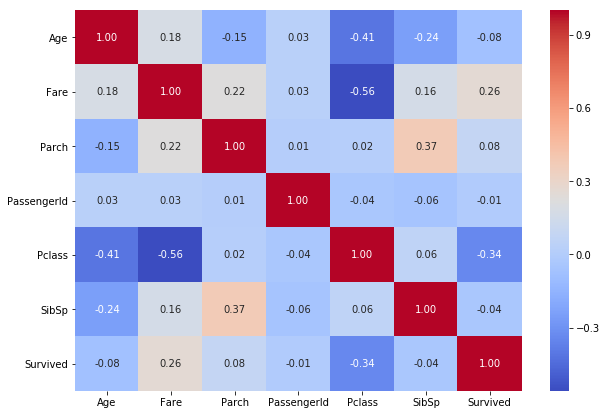

In [13]:
plt.figure(figsize=(10, 7))
sns.heatmap(titanic_data.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

#### Only Fare feature seems to have a significative correlation with the survival probability.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


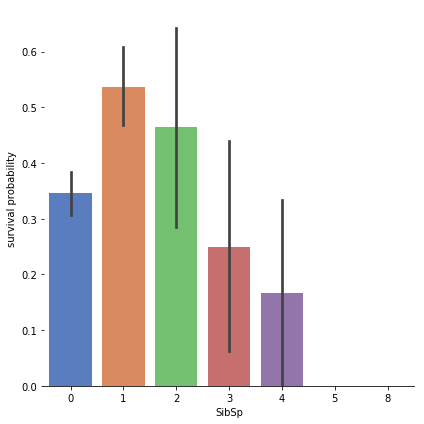

In [14]:
g = sns.factorplot(x="SibSp",y="Survived",data=titanic_data,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

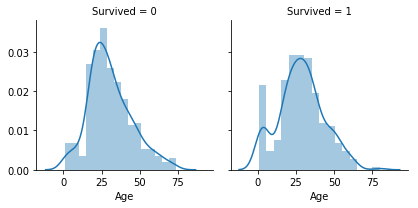

In [15]:
# Explore Age vs Survived
g = sns.FacetGrid(train_df, col='Survived')
g = g.map(sns.distplot, "Age")

Text(0.5, 0, 'Age')

Text(0, 0.5, 'Frequency')

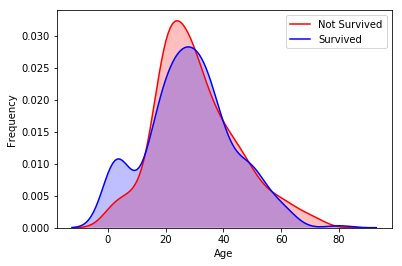

In [16]:
# Explore Age distibution 
g = sns.kdeplot(train_df["Age"][(train_df["Survived"] == 0) & (train_df["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train_df["Age"][(train_df["Survived"] == 1) & (train_df["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

#### We see a peak corresponding to children.

In [17]:
categorical_columns = [x for x in titanic_data.dtypes.index if titanic_data.dtypes[x] =='object'  and x not in ['Cabin', 'Name','Ticket','source']]
categorical_columns

['Embarked', 'Sex']

In [18]:
for column in categorical_columns :
    print('\Frequency of Categories for varible is',column)
    titanic_data[column].value_counts()

\Frequency of Categories for varible is Embarked


S    914
C    270
Q    123
Name: Embarked, dtype: int64

\Frequency of Categories for varible is Sex


male      843
female    466
Name: Sex, dtype: int64

<Figure size 1080x288 with 0 Axes>

Text(0.5, 1.0, 'Embarked count')

Text(0.5, 1.0, 'Sex count')

Text(0.5, 1.0, 'Pclass count')

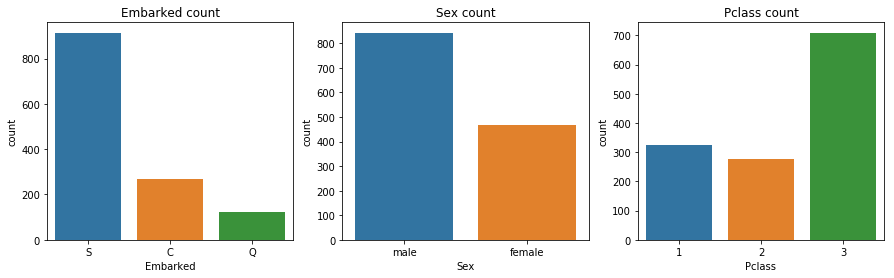

In [19]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
sns.countplot(x='Embarked', data=titanic_data)
plt.title("Embarked count")

plt.subplot(1, 3, 2)
sns.countplot(x='Sex', data=titanic_data)
plt.title("Sex count")

plt.subplot(1, 3, 3)
sns.countplot(x='Pclass', data=titanic_data)
plt.title("Pclass count")

-  ### Maximum people Embarked on Southampton , then on Cherbourg and least people Embarked on Queenstown
-  ### Majority people were Male passengers.
-  ### Majority people were of class 3

<Figure size 1080x288 with 0 Axes>

Text(0.5, 1.0, 'Embarked Survived count')

Text(0.5, 1.0, 'Sex Survived count')

Text(0.5, 1.0, 'Pclass Survived count')

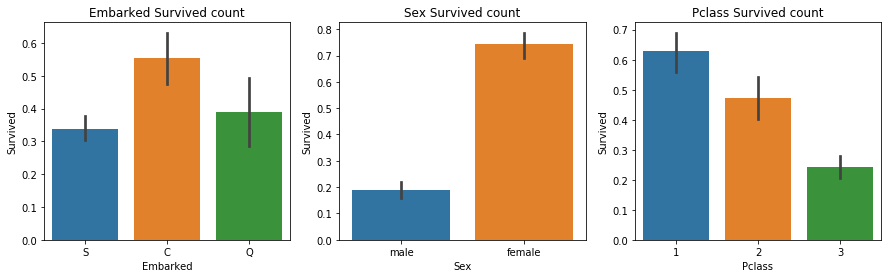

In [20]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
sns.barplot(x='Embarked',y="Survived", data=titanic_data)
plt.title("Embarked Survived count")

plt.subplot(1, 3, 2)
sns.barplot(x='Sex',y="Survived", data=titanic_data)
plt.title("Sex Survived count")

plt.subplot(1, 3, 3)
sns.barplot(x='Pclass',y="Survived", data=titanic_data)
plt.title("Pclass Survived count")

### These Insights are completely different 

-  It seems that passenger coming from Cherbourg (C) have more chance to survive.
-  It is clearly obvious that Male have less chance to survive than Female.
-  First class passengers have more chance to survive than second class and third class passengers.

So Sex, might play an important role in the prediction of the survival.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


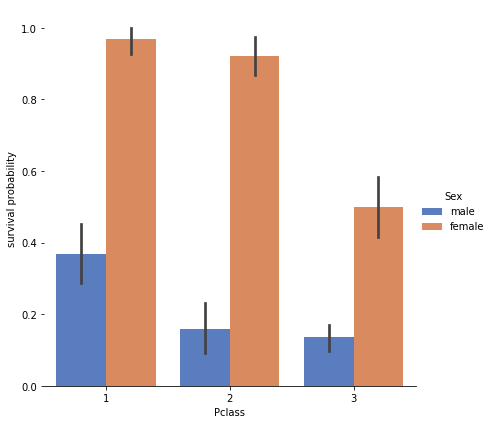

In [21]:
# Explore Pclass vs Survived by Sex
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=titanic_data,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

In [22]:
titanic_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


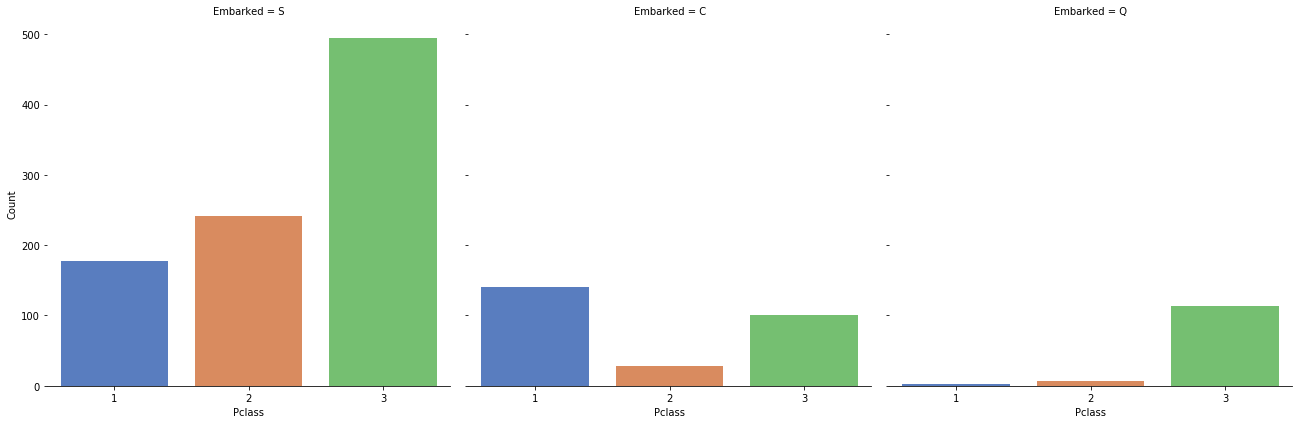

In [23]:
# Explore Pclass vs Embarked 
g = sns.factorplot("Pclass", col="Embarked",  data=titanic_data,
                   size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

## Data Cleaning

In this stage, we will clean our data by
1.  correcting aberrant values and outliers
2.  completing missing information 
3. creating new features for analysis
4. converting fields to the correct format for calculations and presentation.

#### We have missing values in below fields
- Age             263
- Cabin          1014 , handled in feature engineering
- Embarked          2
- Fare              1

In [24]:
#complete missing Age with median
titanic_data['Age'].fillna(titanic_data['Age'].median(), inplace = True)
#complete embarked with mode
titanic_data['Embarked'].fillna(titanic_data['Embarked'].mode()[0],inplace=True)
#complete missing fare with median
titanic_data['Fare'].fillna(titanic_data['Fare'].median(), inplace = True)

In [25]:
titanic_data.apply(lambda x : sum(x.isnull()))

Age               0
Cabin          1014
Embarked          0
Fare              0
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
source            0
dtype: int64

#### We can see there are no missing values except for cabin and Survived(this is out target variable)

### Feature Engineering

In [26]:
titanic_data['Has_Cabin'] = titanic_data["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
titanic_data['FamilySize'] = titanic_data['SibSp'] + titanic_data['Parch'] + 1
#Continuous variable bins
#titanic_data['FareCategory'] = pd.qcut(titanic_data['Fare'], 4)
#titanic_data['AgeCategory'] = pd.cut(titanic_data['Age'].astype(int), 5)

In [27]:
titanic_data.sample(5)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,source,Has_Cabin,FamilySize
500,17.0,NaN,S,8.6625,"Calic, Mr. Petar",0,501,3,male,0,0.0,315086,train,0,1
917,22.0,B36,C,61.9792,"Ostby, Miss. Helene Ragnhild",1,918,1,female,0,NaN,113509,test,1,2
676,24.5,NaN,S,8.0500,"Sawyer, Mr. Frederick Charles",0,677,3,male,0,0.0,342826,train,0,1
199,24.0,NaN,S,13.0000,"Yrois, Miss. Henriette (""Mrs Harbeck"")",0,200,2,female,0,0.0,248747,train,0,1
701,35.0,E24,S,26.2875,"Silverthorne, Mr. Spencer Victor",0,702,1,male,0,1.0,PC 17475,train,1,1


In [28]:
titanic_data[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [29]:
titanic_data.drop(['Ticket', 'Cabin','Name','SibSp','Parch','PassengerId'], axis=1,inplace=True)

In [30]:
titanic_data.sample(5)

,Age,Embarked,Fare,Pclass,Sex,Survived,source,Has_Cabin,FamilySize
277,28.0,S,0.0000,2,male,0.0,train,0,1
1262,31.0,C,134.5000,1,female,NaN,test,1,1
1177,28.0,S,7.2500,3,male,NaN,test,0,1
965,35.0,C,211.5000,1,female,NaN,test,1,1
532,17.0,C,7.2292,3,male,0.0,train,0,3


In [31]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 9 columns):
Age           1309 non-null float64
Embarked      1309 non-null object
Fare          1309 non-null float64
Pclass        1309 non-null int64
Sex           1309 non-null object
Survived      891 non-null float64
source        1309 non-null object
Has_Cabin     1309 non-null int64
FamilySize    1309 non-null int64
dtypes: float64(3), int64(3), object(3)
memory usage: 92.1+ KB


## Converting categorical data to dummy variables for mathematical analysis.

In [32]:
#titanic_data["Pclass"] = titanic_data["Pclass"].astype("category")
#titanic_data["Sex"] = titanic_data["Sex"].astype("category")
#titanic_data["Has_Cabin"] = titanic_data["Has_Cabin"].astype("category")
#titanic_data["Embarked"] = titanic_data["Embarked"].astype("category")

#titanic_data['Sex'].replace(['male','female'],[0,1],inplace=True)
#titanic_data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
from sklearn.preprocessing import LabelEncoder
var_mod = ['Sex','Embarked','Pclass']
le = LabelEncoder()
for i in var_mod:
    titanic_data[i] = le.fit_transform(titanic_data[i])

#dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

In [33]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 9 columns):
Age           1309 non-null float64
Embarked      1309 non-null int32
Fare          1309 non-null float64
Pclass        1309 non-null int64
Sex           1309 non-null int32
Survived      891 non-null float64
source        1309 non-null object
Has_Cabin     1309 non-null int64
FamilySize    1309 non-null int64
dtypes: float64(3), int32(2), int64(3), object(1)
memory usage: 81.9+ KB


In [34]:
titanic_data = pd.get_dummies(titanic_data, columns = ['Pclass','Embarked'])

In [35]:
titanic_data.sample(5)

,Age,Fare,Sex,Survived,source,Has_Cabin,FamilySize,Pclass_0,Pclass_1,Pclass_2,Embarked_0,Embarked_1,Embarked_2
1163,26.0,136.7792,0,NaN,test,1,2,1,0,0,1,0,0
132,47.0,14.5000,0,0.0,train,0,2,0,0,1,0,0,1
76,28.0,7.8958,1,0.0,train,0,1,0,0,1,0,0,1
773,28.0,7.2250,1,0.0,train,0,1,0,0,1,1,0,0
30,40.0,27.7208,1,0.0,train,0,1,1,0,0,1,0,0


In [36]:
#importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix

In [55]:
#Divide into test and train:
train = titanic_data.loc[titanic_data['source']=="train"]
test = titanic_data.loc[titanic_data['source']=="test"]

#Drop unnecessary columns:
test.drop(['source','Survived'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

#Export files as modified versions:
train.to_csv("data/train_modified.csv",index=False)
test.to_csv("data/test_modified.csv",index=False)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [56]:
train.shape

(891, 12)

In [57]:
train.sample(5)

,Age,Fare,Sex,Survived,Has_Cabin,FamilySize,Pclass_0,Pclass_1,Pclass_2,Embarked_0,Embarked_1,Embarked_2
47,28.0,7.75,0,1.0,0,1,0,0,1,0,1,0
472,33.0,27.75,0,1.0,0,4,0,1,0,0,0,1
724,27.0,53.10,1,1.0,1,2,1,0,0,0,0,1
635,28.0,13.00,0,1.0,0,1,0,1,0,0,0,1
106,21.0,7.65,0,1.0,0,1,0,0,1,0,0,1


In [58]:
test.sample(4)

,Age,Fare,Sex,Has_Cabin,FamilySize,Pclass_0,Pclass_1,Pclass_2,Embarked_0,Embarked_1,Embarked_2
1177,28.0,7.250,1,0,1,0,0,1,0,0,1
1256,28.0,69.550,0,0,11,0,0,1,0,0,1
1105,38.0,7.775,0,0,7,0,0,1,0,0,1
898,26.0,29.000,1,0,3,0,1,0,0,0,1


In [59]:
train_X = train.drop('Survived',axis=1)
train_Y = train['Survived']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(train_X,train_Y,test_size=0.2,random_state=8)

### Model building using Naive Bayes


In [64]:
naive_model = GaussianNB()
naive_model.fit(X_train,y_train) 
y_pred_naive = naive_model.predict(X_test)

GaussianNB(priors=None, var_smoothing=1e-09)

In [67]:
print("Accuracy score is %f"%naive_model.score(X_test,y_test))

Accuracy score is 0.731844


In [65]:
print(metrics.confusion_matrix(y_test, y_pred_naive))
print(metrics.classification_report(y_test, y_pred_naive))

[[90 18]
 [30 41]]
              precision    recall  f1-score   support

         0.0       0.75      0.83      0.79       108
         1.0       0.69      0.58      0.63        71

   micro avg       0.73      0.73      0.73       179
   macro avg       0.72      0.71      0.71       179
weighted avg       0.73      0.73      0.73       179



In [49]:
passengerId = test_df['PassengerId']

In [50]:
# Generate Submission File 
NaiveBayesSubmission = pd.DataFrame({ 'PassengerId': passengerId,
                            'Survived': y_pred_naive })
NaiveBayesSubmission.to_csv("Submission/naive_model_Submission.csv", index=False)

In [68]:
rf_500 = RandomForestClassifier(n_jobs=2,n_estimators=500,criterion="entropy",random_state=8)
rf_500.fit(X_train,y_train)
y_pred_RandomForest = rf_500.predict(X_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=2,
            oob_score=False, random_state=8, verbose=0, warm_start=False)

In [69]:
print("Accuracy score is %f"%rf_500.score(X_test,y_test))
print(metrics.confusion_matrix(y_test, y_pred_RandomForest))
print(metrics.classification_report(y_test, y_pred_RandomForest))

Accuracy score is 0.798883
[[88 20]
 [16 55]]
              precision    recall  f1-score   support

         0.0       0.85      0.81      0.83       108
         1.0       0.73      0.77      0.75        71

   micro avg       0.80      0.80      0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



In [71]:
# Generate Submission File 
y_pred = rf_500.predict(test)
RandomForestSubmission = pd.DataFrame({ 'PassengerId': passengerId,
                            'Survived': y_pred })
RandomForestSubmission.to_csv("Submission/submission.csv", index=False)